## Задание №1
**Пояснение к формату:**
login — логин асессора; 
tid — id оцениваемого задания (task id); 
Microtasks – количество микрозаданий в одном задании; 
assigned_ts — время резервирования системой задания для асессора; 
closed_ts — точное время завершения работы над заданием; разделитель — табуляция \t.

Задание может состоять из одного или несколько микрозаданий. Время резервирования задания (assigned_ts) указывает на тот момент, когда система назначила определенного асессора исполнителем этого задания. Этот момент может совпадать с временем начала работы асессора над заданием, а может и не совпадать (асессор может отойти выпить чаю, а потом приступить к заданию, асессор может выполнять предыдущее задание, в то время как за ним зарезервированы новые).

Предположим, что асессор за 30 секунд своего рабочего времени получает N рублей.

**Какую оплату вы считаете справедливой для выполнения асессором одного микрозадания из этого файла?** Опишите подробно все этапы вашего решения.

#### Шаг1 Для начала подготовим данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display as show
df = pd.read_csv('data_task4_old.txt', sep='\t')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   login        701827 non-null  object 
 1   tid          701827 non-null  float64
 2   Microtasks   701827 non-null  float64
 3   assigned_ts  701827 non-null  object 
 4   closed_ts    701827 non-null  object 
dtypes: float64(2), object(3)
memory usage: 26.8+ MB


In [3]:
#Для дальнейшего удобства переименую столбцы и поменяю типы данных для возможности вычислений

#df.rename(columns = {'assigned_ts':'start', 'closed_ts':'end'}, inplace = True)
df['tid']=df['tid'].astype('int')
df['Microtasks'].astype('int')
df['open'] = pd.to_datetime(df.assigned_ts)
df['closed'] = pd.to_datetime(df.closed_ts)
del df['assigned_ts'], df['closed_ts']

In [4]:
#Выведу общую статистику

df.describe()

,tid,Microtasks
count,7.018270e+05,701827.00000
mean,1.884911e+08,3.25439
std,1.391113e+07,3.65397
min,1.139586e+08,1.00000
25%,1.906846e+08,1.00000
50%,1.935373e+08,2.00000
75%,1.963667e+08,4.00000
max,1.985758e+08,50.00000


In [5]:
#проверка значений с NaN (таких не оказалось)

np.where(pd.isnull(df))


#поиск дубликатов

df[df.duplicated(keep=False)].head()

,login,tid,Microtasks,open,closed
27154,login16,189549650,1.0,2017-04-21 06:32:24,2017-04-24 02:56:29
27155,login16,191410866,1.0,2017-04-24 02:56:22,2017-04-24 02:56:48
27156,login16,191411008,3.0,2017-04-24 02:56:29,2017-04-24 02:57:36
27157,login16,191410632,1.0,2017-04-24 02:56:49,2017-04-24 02:58:14
27158,login16,191410500,1.0,2017-04-24 02:57:40,2017-04-24 02:58:31


In [6]:
#удаление дубликатов

df = df.drop_duplicates()
df.describe()              #общие данные немного уменьшились

,tid,Microtasks
count,6.800370e+05,680037.000000
mean,1.885684e+08,3.245282
std,1.367803e+07,3.646966
min,1.139586e+08,1.000000
25%,1.906846e+08,1.000000
50%,1.935639e+08,2.000000
75%,1.963753e+08,4.000000
max,1.985758e+08,50.000000


In [7]:
#Время выполнения сессии в секундах

df['runtime']=(df['closed']-df['open']).dt.total_seconds().astype(int)
df['runtime'].describe().astype(int)

#Время выполнения 1 задания в секундах

df['task_runtime']=(df['runtime']/df['Microtasks'])
df['task_runtime'].astype(int)
df.head()

,login,tid,Microtasks,open,closed,runtime,task_runtime
0,login0,190563850,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01,3802,950.50
1,login0,190561754,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29,1079,1079.00
2,login0,190565906,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10,4119,1029.75
3,login0,190560246,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56,2726,2726.00
4,login0,190562168,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50,2768,1384.00


In [8]:
#Отсутствует корреляция у кол-во задач и времени на их затрату, то есть на одну задачу разные асессоры тратят абсолютно разное время

df[['Microtasks', 'runtime']].corr()

,Microtasks,runtime
Microtasks,1.000000,0.192711
runtime,0.192711,1.000000


In [9]:
#создаю свобную таблицу чтобы сгруппировать данные и посчитать среднее время выполнения задач внутри нее

pivot=pd.pivot_table(df, values = ['runtime', 'Microtasks'], index = 'login', aggfunc = 'sum')
pivot['task_runtime'] = pivot.runtime/pivot.Microtasks
pivot.head()

,Microtasks,runtime,task_runtime
login,,,
login0,2172.0,1820211,838.034530
login1,3513.0,405881,115.536863
login10,136.0,300849,2212.125000
login100,65.0,8406,129.323077
login101,11750.0,1795217,152.784426


In [10]:
pivot.describe()

,Microtasks,runtime,task_runtime
count,767.000000,7.670000e+02,767.000000
mean,2877.329857,1.670396e+06,1083.447669
std,4558.582749,3.183216e+06,2386.665231
min,1.000000,2.200000e+01,22.000000
25%,363.500000,1.626270e+05,145.167844
50%,1358.000000,5.672610e+05,370.529494
75%,3437.500000,1.530726e+06,1207.438160
max,51402.000000,2.270733e+07,44967.119284


**Получил сколько асессер в среднем тратит времени на 1 задачу - 1083 секунду.** Причем минимальное 22 сек и максимальное 44 957

**НО** такой подход не совсем верный, потому что не учивывает что асессор в один промежуток времени может выполнять несколько задач. Чтобы это учесть необходимо сгруппировать временные промежутки которые пересекаются и посчитать данные внутри них.

Проверим разлет времени, сколько асессор по графику

Text(0, 0.5, 'Среднее время выполнения 1 задания')

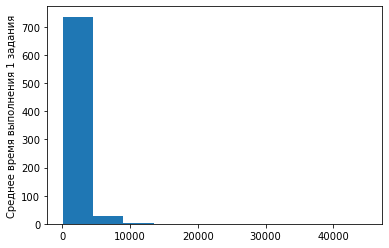

In [11]:
pivot['task_runtime'].plot(kind='hist')
plt.ylabel('Среднее время выполнения 1 задания')

**Далее будут мои предположения по следующим шагам:**
Нужно сделать группировку пересекающихся временных промежутков и посчитать данные внутри них, через .groupby и pivot это не работает, так как надо перебирать временные промежутки, это можно сделать через функции или модули. Я знаю как создавать базовые простые функции и объединять их в модули, но пока, к сожалению, не могу сделать такой перебор.

После выполнения функции должна получиться таблица, где после агрегации видно, что асессор Х имеет ряд временых промежутков, пример ниже:

login | open | closed | sum Microtasks | Runtime | task_runtime
--- | --- | --- | --- | --- | --- |
login0 | 2017-04-20 12:09:39 | 2017-04-20 13:14:50 | 15| 780 | 80

То есть в данном случае промежуток между началом и концом работы должен вмещать в себя ряд записей, а не одну как я считал ранее. Такой подсчет считаю будет более корректный.




**Исходя из полученной таблицы можно будет получить:**
1. Сколько действительно времени асессор тратит время на задачу
2. Сколько задач асессор может исполнить в день и сколько времени он тратит на каждую из них
3. Сравнить на графике какие асессоры за какой средний промежуток времени выполняют 1 задачу, и сколько из них управляется в 30 секунд (судя по данным подсчитаным мной ранее на выполнение задачи асессору вообще требуется порядка 700 секунд, но повторюсь, я бы не брал эти данные за основу).


### Вывод:
Достаточно затруднительно ответить на вопрос *сколько* именно стоит платить асессору за 30 секунд его работы, скорее в данном расчете можно только определить почему именно 30 секунд и хватит ли среднему асессору этого времени на выполнение одной задачи. Так же стоит учесть, что уровень асессоров может быть разный, как видно на статистической таблица в среднем у асесосора на задачу уходит 700 сек, а диапозон от минимального до максимльное время составляет от 22 сек до 44900. Это очень большой разброс, чему свидетельствует стандартное отклонение в 2386 сек